In [1]:
# ============================
# Cell 1: Import & 환경설정
# ============================
import os
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_H, IMG_W = 380, 380  # 이미지 크기 설정

print("="*60)
print("🚀 TTA + SwinIR 추론 환경 설정")
print("="*60)
print(f"🖥️ Device: {DEVICE}")
print(f"📐 Image Size: {IMG_H}x{IMG_W}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*60)

🚀 TTA + SwinIR 추론 환경 설정
🖥️ Device: cuda
📐 Image Size: 380x380
🎮 GPU: NVIDIA GeForce RTX 3090
💾 GPU Memory: 23.69 GB


In [2]:
# SwinIR pretrained weights 다운로드 (color denoising model)
!mkdir -p experiments/pretrained_models
!wget -O experiments/pretrained_models/005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth \
https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth

print("✅ SwinIR 가중치 다운로드 완료!")


--2025-11-10 14:57:05--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/396770997/4682ea0f-52b8-40ab-994b-c5a823c1cc15?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-10T06%3A30%3A45Z&rscd=attachment%3B+filename%3D005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-10T05%3A30%3A33Z&ske=2025-11-10T06%3A30%3A45Z&sks=b&skv=2018-11-09&sig=qZFAGQB8FH2IcOLM1UFimFTo3%2FcfxzLwWP60Mpa5u6M%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2Mjc1NzgyNiwibmJm

In [3]:
# ============================
# Cell 2: SwinIR 모델 로드
# ============================
# SwinIR 모델을 사용하여 이미지 denoising 수행
# 주의: SwinIR 라이브러리가 설치되어 있어야 합니다.
#!git clone https://github.com/JingyunLiang/SwinIR.git
import sys, os, torch

# SwinIR 경로 추가 (한 번만)
sys.path.append("./SwinIR")

try:
    from models.network_swinir import SwinIR
    SWINIR_AVAILABLE = True
    print("✅ SwinIR import 및 로드 완료")
except ImportError as e:
    SWINIR_AVAILABLE = False
    print("⚠️ SwinIR 라이브러리를 찾을 수 없습니다:", e)
    print("   SwinIR을 사용하지 않고 진행합니다.")

def load_swinir_model(weight_path, device):
    """
    SwinIR 모델 로드
    Args:
        weight_path: SwinIR 모델 가중치 경로
        device: torch device
    Returns:
        model: 로드된 SwinIR 모델
    """
    if not SWINIR_AVAILABLE:
        raise ImportError("SwinIR 라이브러리가 설치되지 않았습니다.")
    
    model = SwinIR(
        upscale=1,
        in_chans=3,
        img_size=64,
        window_size=8,
        img_range=1.0,
        depths=[6, 6, 6, 6],
        embed_dim=60,
        num_heads=[6, 6, 6, 6],
        mlp_ratio=2,
        upsampler='',
        resi_connection='1conv'
    )
    
    if os.path.exists(weight_path):
        pretrained = torch.load(weight_path, map_location=device)
        model.load_state_dict(pretrained, strict=False)
        model.eval().to(device)
        print(f"✅ SwinIR 모델 로드 완료: {weight_path}")
    else:
        print(f"⚠️ SwinIR 가중치 파일을 찾을 수 없습니다: {weight_path}")
        print("   SwinIR을 사용하지 않고 진행합니다.")
        model = None
    
    return model

# SwinIR 모델 로드 (옵션)
USE_SWINIR = True  # SwinIR 사용 여부 (True로 설정하면 사용)
swinir_model = None

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if USE_SWINIR and SWINIR_AVAILABLE:
    swinir_model = load_swinir_model('experiments/pretrained_models/005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth', DEVICE)
    if swinir_model is not None:
        print("✅ SwinIR 모델 활성화됨")
    else:
        USE_SWINIR = False
        print("⚠️ SwinIR 모델을 사용할 수 없습니다. TTA만 사용합니다.")
else:
    print("ℹ️ SwinIR 사용 안 함 (USE_SWINIR=False 또는 라이브러리 없음)")

✅ SwinIR import 및 로드 완료
✅ SwinIR 모델 로드 완료: experiments/pretrained_models/005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth
✅ SwinIR 모델 활성화됨


In [5]:
# ============================
# Cell 2: 테스트 데이터셋 정의
# ============================
class TestDataset(Dataset):
    def __init__(self, img_dir, img_names, img_h, img_w):
        self.img_dir = img_dir
        self.img_names = img_names
        self.img_h = img_h
        self.img_w = img_w
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # 이미지 로드
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"이미지를 로드할 수 없습니다: {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 원본 이미지(numpy array)와 파일명 반환
        # TTA를 위해 원본 이미지가 필요하므로 변환하지 않음
        return {'image': image, 'img_name': img_name}

In [6]:
# ============================
# Cell 3: 모델 불러오기 함수들
# ============================
import timm
from efficientnet_pytorch import EfficientNet
from torchvision.models import convnext_base
import torch.nn as nn

class EfficientNetClassifier(nn.Module):
    def __init__(self, model_name='efficientnet-b4', num_classes=17):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained(model_name)
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        return self.backbone(x)

# class ViTClassifier(nn.Module):
#     def __init__(self, model_name='vit_base_patch16_224', num_classes=17):
#         super().__init__()
#         self.backbone = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
#     def forward(self, x):
#         return self.backbone(x)

# class ConvNeXtClassifier(nn.Module):
#     def __init__(self, num_classes=17):
#         super().__init__()
#         self.backbone = convnext_base(weights=None)
#         in_features = self.backbone.classifier[2].in_features
#         self.backbone.classifier[2] = nn.Linear(in_features, num_classes)
#     def forward(self, x):
#         return self.backbone(x)

In [7]:
# ============================
# Cell 5: SwinIR Denoising 함수
# ============================
def apply_swinir_denoise(image, swinir_model, device):
    """
    SwinIR 모델을 사용하여 이미지 denoising 수행
    Args:
        image: numpy array (H, W, C) 형태의 이미지, uint8 (0-255)
        swinir_model: 로드된 SwinIR 모델
        device: torch device
    Returns:
        denoised_image: denoising된 numpy array 이미지, uint8 (0-255)
    """
    if swinir_model is None:
        return image
    
    swinir_model.eval()
    
    # 이미지를 0-1 범위로 정규화
    img_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        # SwinIR 추론
        output = swinir_model(img_tensor)
        
        # 0-255 범위로 변환
        output = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
        output = np.clip(output * 255.0, 0, 255).astype(np.uint8)
    
    return output

print("✅ SwinIR Denoising 함수 정의 완료")


✅ SwinIR Denoising 함수 정의 완료


In [8]:
# ============================
# Cell 4: TTA 변환 함수 정의
# ============================
def get_tta_transforms(img_h, img_w):
    transforms = []
    transforms.append(A.Compose([
        A.Resize(img_h, img_w),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ]))
    transforms.append(A.Compose([
        A.HorizontalFlip(p=1.0),
        A.Resize(img_h, img_w),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ]))
    transforms.append(A.Compose([
        A.VerticalFlip(p=1.0),
        A.Resize(img_h, img_w),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ]))
    transforms.append(A.Compose([
        A.Rotate(limit=(90,90), p=1.0),
        A.Resize(img_h, img_w),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ]))
    return transforms

# 각 모델에 맞는 TTA 변환 생성
# EfficientNet-B4: 380x380 (학습 시 사용한 크기)
# ViT: 224x224 (학습 시 사용한 크기)
# ConvNeXt: 380x380 (학습 시 사용한 크기)
tta_transforms_b4 = get_tta_transforms(380, 380)
# tta_transforms_vit = get_tta_transforms(224, 224)
# tta_transforms_convnext = get_tta_transforms(380, 380)

print("✅ TTA 변환 준비 완료:")
print(f"  - EfficientNet-B4: {len(tta_transforms_b4)}개 변환 (380x380)")
# print(f"  - ViT: {len(tta_transforms_vit)}개 변환 (224x224)")
# print(f"  - ConvNeXt: {len(tta_transforms_convnext)}개 변환 (380x380)")


✅ TTA 변환 준비 완료:
  - EfficientNet-B4: 4개 변환 (380x380)


In [9]:
# ============================
# Cell 5: TTA 추론 함수
# ============================
def tta_inference(model, image, transforms, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for t in transforms:
            augmented = t(image=image)['image'].unsqueeze(0).to(device)
            output = model(augmented)
            prob = F.softmax(output, dim=1).cpu().numpy()
            preds.append(prob)
    avg_prob = np.mean(preds, axis=0)
    return avg_prob


In [10]:
# ============================
# Cell 6: 모델 로드
# ============================
print("🔄 모델 로드 중...")

# EfficientNet-B4 모델 로드
try:
    model_b4 = EfficientNetClassifier().to(DEVICE)
    model_b4.load_state_dict(torch.load('best_efficientnet_b4.pth', map_location=DEVICE))
    model_b4.eval()
    print("✅ EfficientNet-B4 로드 완료")
except Exception as e:
    print(f"❌ EfficientNet-B4 로드 실패: {e}")
    raise

# ViT 모델 로드
# try:
#     model_vit = ViTClassifier().to(DEVICE)
#     model_vit.load_state_dict(torch.load('best_vit.pth', map_location=DEVICE))
#     model_vit.eval()
#     print("✅ ViT 로드 완료")
# except Exception as e:
#     print(f"❌ ViT 로드 실패: {e}")
#     raise

# # ConvNeXt 모델 로드
# try:
#     model_convnext = ConvNeXtClassifier().to(DEVICE)
#     model_convnext.load_state_dict(torch.load('best_convnext.pth', map_location=DEVICE))
#     model_convnext.eval()
#     print("✅ ConvNeXt 로드 완료")
# except Exception as e:
#     print(f"❌ ConvNeXt 로드 실패: {e}")
#     raise

print("🎉 모든 모델 로드 완료!")


🔄 모델 로드 중...
Loaded pretrained weights for efficientnet-b4
✅ EfficientNet-B4 로드 완료
🎉 모든 모델 로드 완료!


In [11]:
# ============================
# Cell 7: Test 데이터셋 및 DataLoader 준비
# ============================
# TestDataset은 Cell 2에서 이미 정의되어 있습니다 (원본 이미지 반환)
# TTA를 위해 원본 이미지(numpy array)가 필요하므로 Cell 2의 버전을 사용합니다.

def custom_collate_fn(batch):
    """
    딕셔너리 형태의 배치를 처리하는 custom collate function
    원본 이미지(numpy array)를 그대로 유지하기 위해 필요
    """
    images = [item['image'] for item in batch]
    img_names = [item['img_name'] for item in batch]
    return {'image': images, 'img_name': img_names}

test_img_dir = 'test'  # 테스트 이미지 폴더 경로
if not os.path.exists(test_img_dir):
    raise ValueError(f"테스트 이미지 디렉토리가 없습니다: {test_img_dir}")

test_img_names = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.jpg')])
print(f"📁 테스트 이미지 개수: {len(test_img_names)}개")

# Cell 2에서 정의한 TestDataset 사용 (원본 이미지 반환)
test_dataset = TestDataset(test_img_dir, test_img_names, IMG_H, IMG_W)
test_loader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=0,
    collate_fn=custom_collate_fn
)
print("✅ Test DataLoader 준비 완료!")

📁 테스트 이미지 개수: 3140개
✅ Test DataLoader 준비 완료!


In [15]:
# ============================
# Cell 8: 전체 TTA + SwinIR 추론 후 앙상블
# ============================
# 각 모델에 맞는 TTA 변환 사용 (Cell 5에서 정의됨)
print("="*60)
print("🚀 TTA + SwinIR 추론 시작")
print("="*60)
print(f"📊 사용 모델: EfficientNet-B4, ViT, ConvNeXt")
print(f"⚖️ 앙상블 가중치: B4(0.4), ViT(0.35), ConvNeXt(0.25)")
print(f"🔀 TTA 변환:")
print(f"  - EfficientNet-B4: {len(tta_transforms_b4)}개 (380x380)")
# print(f"  - ViT: {len(tta_transforms_vit)}개 (224x224)")
# print(f"  - ConvNeXt: {len(tta_transforms_convnext)}개 (380x380)")
print(f"🔧 SwinIR Denoising: {'✅ 사용' if USE_SWINIR and swinir_model is not None else '❌ 사용 안 함'}")
print("="*60 + "\n")

predictions = []
for batch in tqdm(test_loader, desc="TTA + SwinIR 추론 진행"):
    # custom_collate_fn으로 인해 배치는 {'image': [image], 'img_name': [img_name]} 형태
    images = batch['image']  # 리스트
    img_names = batch['img_name']  # 리스트
    
    # batch_size=1이므로 첫 번째 요소 추출
    image = images[0]  # numpy array (H, W, C), uint8
    img_name = img_names[0]  # 파일명 (string)
    
    # SwinIR denoising 적용 (옵션)
    if USE_SWINIR and swinir_model is not None:
        image = apply_swinir_denoise(image, swinir_model, DEVICE)
    
    # 각 모델별 TTA 추론 (각 모델에 맞는 변환 사용)
    prob_b4 = tta_inference(model_b4, image, tta_transforms_b4, DEVICE)
    # prob_vit = tta_inference(model_vit, image, tta_transforms_vit, DEVICE)
    # prob_convnext = tta_inference(model_convnext, image, tta_transforms_convnext, DEVICE)
    
    # 가중 앙상블 비율: 조정 가능
    #ensemble_prob = (prob_b4 * 0.4 + prob_vit * 0.35 + prob_convnext * 0.25)
    
    # argmax로 예측 클래스 추출
    # ensemble_prob shape: (1, num_classes)
    #pred_class = ensemble_prob.argmax(axis=1)[0]
    
#     predictions.append({'ID': img_name, 'target': int(pred_class)})

# print(f"\n✅ 추론 완료: {len(predictions)}개 이미지 처리")
    pred_class = prob_b4.argmax(axis=1)[0]
    
    predictions.append({'ID': img_name, 'target': int(pred_class)})

print(f"\n✅ 추론 완료: {len(predictions)}개 이미지 처리")


🚀 TTA + SwinIR 추론 시작
📊 사용 모델: EfficientNet-B4, ViT, ConvNeXt
⚖️ 앙상블 가중치: B4(0.4), ViT(0.35), ConvNeXt(0.25)
🔀 TTA 변환:
  - EfficientNet-B4: 4개 (380x380)
🔧 SwinIR Denoising: ✅ 사용



TTA + SwinIR 추론 진행: 100%|██████████| 3140/3140 [1:23:23<00:00,  1.59s/it]


✅ 추론 완료: 3140개 이미지 처리


In [16]:
# ============================
# Cell 9: 제출 파일 저장
# ============================
if len(predictions) == 0:
    print("❌ 예측 결과가 없습니다. 먼저 Cell 8을 실행하세요.")
else:
    submission = pd.DataFrame(predictions)
    swinir_suffix = '_swinir' if (USE_SWINIR and swinir_model is not None) else ''
    submission_filename = f'submission_enb4_tta_single{swinir_suffix}.csv'
    submission.to_csv(submission_filename, index=False)
    
    print("="*60)
    print("📝 제출 파일 저장 완료")
    print("="*60)
    print(f"✅ 파일명: {submission_filename}")
    print(f"📊 총 예측 개수: {len(submission)}개")
    print(f"🔧 SwinIR 사용: {'✅ 예' if (USE_SWINIR and swinir_model is not None) else '❌ 아니오'}")
    print(f"\n📈 클래스별 예측 분포:")
    class_counts = submission['target'].value_counts().sort_index()
    for class_id, count in class_counts.items():
        print(f"  클래스 {class_id}: {count}개 ({count/len(submission)*100:.2f}%)")
    print("="*60)

📝 제출 파일 저장 완료
✅ 파일명: submission_enb4_tta_single_swinir.csv
📊 총 예측 개수: 3140개
🔧 SwinIR 사용: ✅ 예

📈 클래스별 예측 분포:
  클래스 0: 207개 (6.59%)
  클래스 2: 534개 (17.01%)
  클래스 3: 66개 (2.10%)
  클래스 5: 13개 (0.41%)
  클래스 6: 7개 (0.22%)
  클래스 7: 72개 (2.29%)
  클래스 8: 11개 (0.35%)
  클래스 9: 9개 (0.29%)
  클래스 10: 10개 (0.32%)
  클래스 11: 242개 (7.71%)
  클래스 13: 1962개 (62.48%)
  클래스 14: 1개 (0.03%)
  클래스 15: 1개 (0.03%)
  클래스 16: 5개 (0.16%)


📊 예측 결과 분석:
총 예측 개수: 3140
🔧 SwinIR 사용: ✅ 예

클래스별 예측 분포:
target
0      207
2      534
3       66
5       13
6        7
7       72
8       11
9        9
10      10
11     242
13    1962
14       1
15       1
16       5
Name: count, dtype: int64


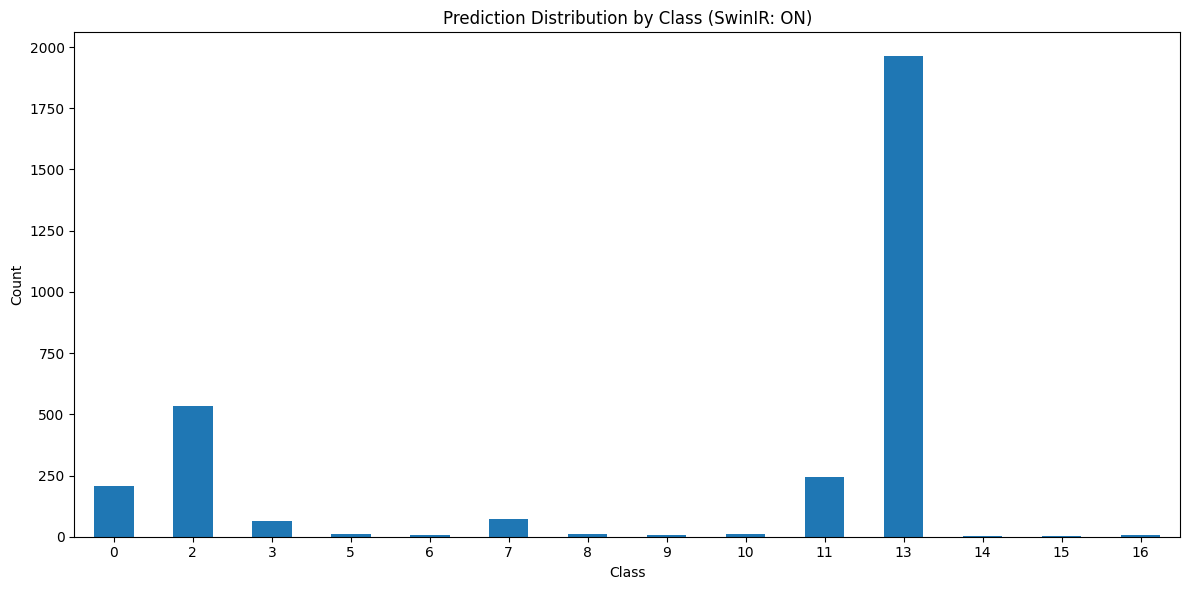

In [18]:
# ============================
# Cell 10: 예측 결과 분석 (선택사항)
# ============================
swinir_suffix = '_swinir' if (USE_SWINIR and swinir_model is not None) else ''
submission_filename = f'submission_enb4_tta_single{swinir_suffix}.csv'

if os.path.exists(submission_filename):
    submission_df = pd.read_csv(submission_filename)
    
    print("📊 예측 결과 분석:")
    print(f"총 예측 개수: {len(submission_df)}")
    print(f"🔧 SwinIR 사용: {'✅ 예' if (USE_SWINIR and swinir_model is not None) else '❌ 아니오'}")
    print(f"\n클래스별 예측 분포:")
    print(submission_df['target'].value_counts().sort_index())
    
    # 클래스 분포 시각화
    plt.figure(figsize=(12, 6))
    submission_df['target'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Prediction Distribution by Class (SwinIR: {"ON" if (USE_SWINIR and swinir_model is not None) else "OFF"})')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("제출 파일이 없습니다. 먼저 추론을 실행하세요.")
